In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset_contour import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx
from torchvision.transforms import GaussianBlur
# from hybrid_model_v1 import HybridSegModel
from hybrid_model_v3_contour import HybridSegModel_contour

/opt/anaconda3/envs/thyroid/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/thyroid/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/opt/anaconda3/envs/thyroid/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
import wandb
# wandb.login()

In [5]:
image_size = 128
batch_size = 100
def train_augmentation(image, mask, image_size):

    p = 0.5
    
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness=0.5)
    #     image = jitter(image)
    # if(random.random() < p):
    #     angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
    #     translate = (random.uniform(-0.05, 0.05) * image.size[0],
    #                  random.uniform(-0.05, 0.05) * image.size[1])  # 最多平移 ±5%
    #     scale = random.uniform(0.95, 1.05)  # 尺度縮放 ±5%
    #     shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
    
    #     image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
    #     mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)
    # if random.random() < p:
    #     image = F.hflip(image)
    #     mask = F.hflip(mask)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

    
train_dataset = Thyroid_Dataset("train_v2.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("test_v2.csv", transform = test_augmentation, image_size = image_size, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

image, mask, contour, seg_type = next(iter(train_dataloader))
image = image
mask = mask

In [6]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))
print("unique : ", torch.unique(contour))

std :  tensor(1.0000)
unique :  tensor([0., 1.])
unique :  tensor([0., 1.])


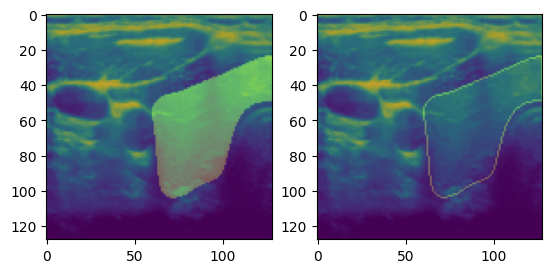

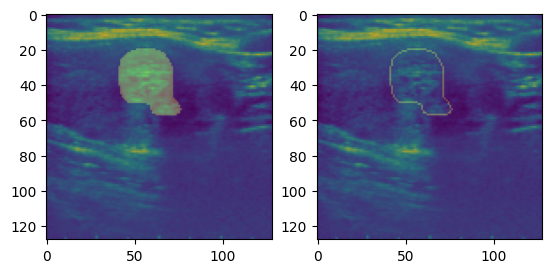

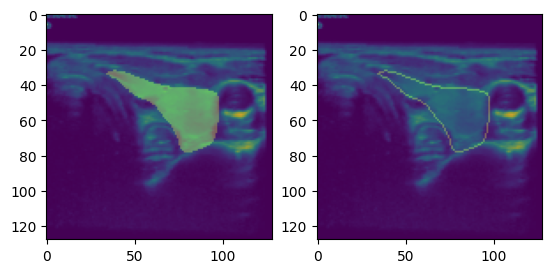

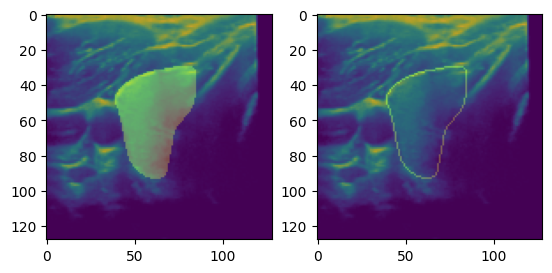

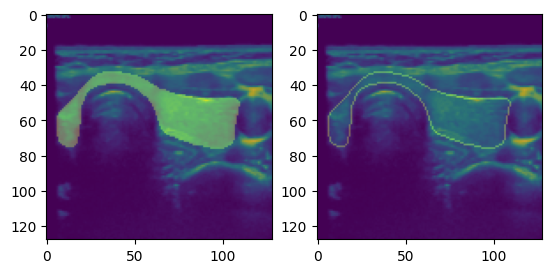

In [7]:
index = 39
for index in range(5):
    plt.subplot(1,2,1)
    # plt.imshow(mask[index][0], alpha = 0.3)
    plt.imshow(image[index][0])
    plt.imshow(mask[index][0], alpha = 0.3)
    
    plt.subplot(1,2,2)
    plt.imshow(image[index][0])
    plt.imshow(contour[index][0], alpha = 0.3)
    plt.show()

In [47]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
# model = HarDMSEG(in_channels = 1)
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")
model = HybridSegModel_contour(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)

In [48]:
def dice_loss_contour(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

In [49]:
image_loss_fn_nodule = StructureLoss()
image_loss_fn_gland = StructureLoss()

contour_loss_fn_nodule = dice_loss_contour
contour_loss_fn_gland = dice_loss_contour



In [50]:
# model.to("cuda")
# image = image.to("cuda")
# mask = mask.to("cuda")

In [51]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
# for epoch in range(1000):
#     image_pred, contour_pred = model(image)

#     nodule_image_pred = image_pred[:, 0:1][seg_type==1]
#     gland_image_pred = image_pred[:, 1:2][seg_type==2]
#     nodule_image_mask = mask[seg_type==1]
#     gland_image_mask = mask[seg_type==2]

#     nodule_contour_pred = contour_pred[:, 0:1][seg_type==1]
#     gland_contour_pred = contour_pred[:, 1:2][seg_type==2]
#     nodule_contour_mask = contour[seg_type==1]
#     gland_contour_mask = contour[seg_type==2]

#     nodule_image_loss = image_loss_fn_nodule(nodule_image_pred, nodule_image_mask)
#     gland_image_loss = image_loss_fn_gland(gland_image_pred, gland_image_mask)
    
#     nodule_contour_loss = contour_loss_fn_nodule(nodule_contour_pred, nodule_contour_mask)
#     gland_contour_loss = contour_loss_fn_gland(gland_contour_pred, gland_contour_mask)
    
#     loss = nodule_image_loss + gland_image_loss + nodule_contour_loss + gland_contour_loss

#     nodule_image_IOU = IOU_score(nodule_image_pred, nodule_image_mask)
#     gland_image_IOU = IOU_score(gland_image_pred, gland_image_mask)
    
#     IOU = (nodule_image_IOU + gland_image_IOU) / 2
    
#     dice_loss = DiceLoss()

#     nodule_image_DICE = 1 - dice_loss(nodule_image_pred, nodule_image_mask)
#     gland_image_DICE = 1 - dice_loss(gland_image_pred, gland_image_mask)
    
#     DICE = (nodule_image_DICE + gland_image_DICE) / 2
    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights

#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

Epoch 1, Loss: 1.9501


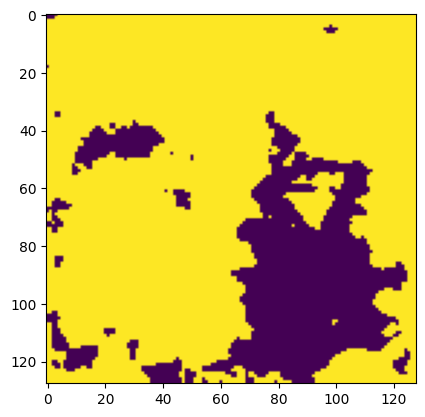

Epoch 2, Loss: 1.8298


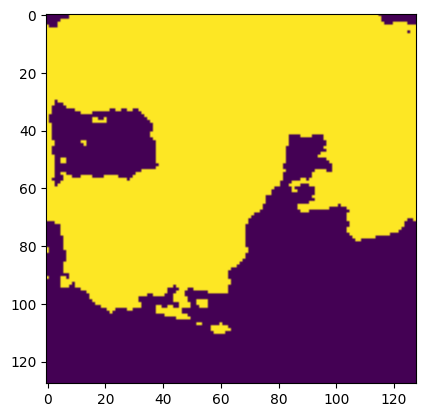

Epoch 3, Loss: 2.0153


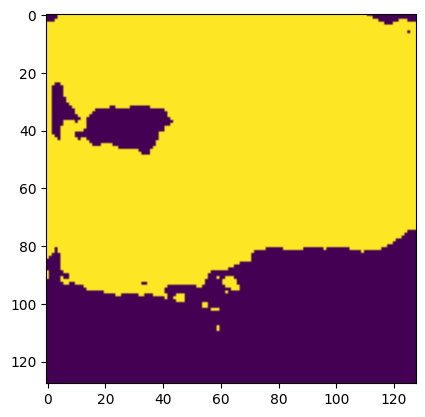

Epoch 4, Loss: 1.9328


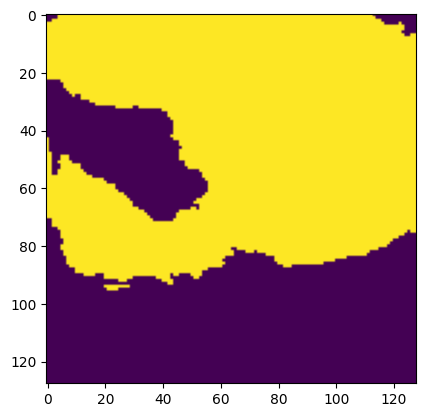

Epoch 5, Loss: 1.9812


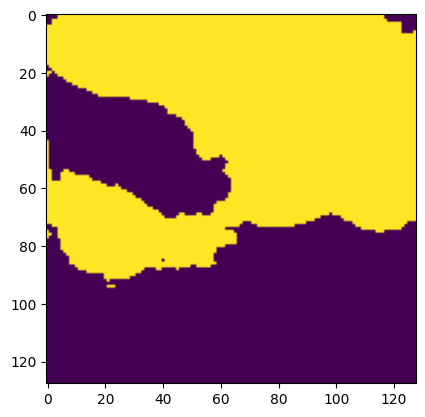

Epoch 6, Loss: 2.0262


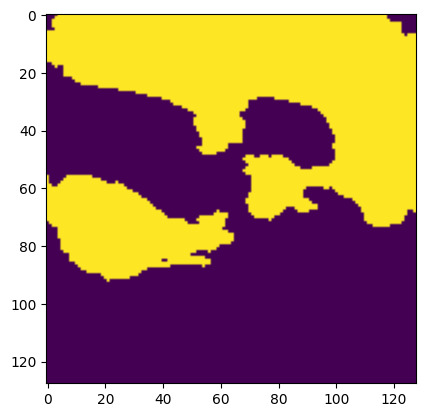

Epoch 7, Loss: 2.0519


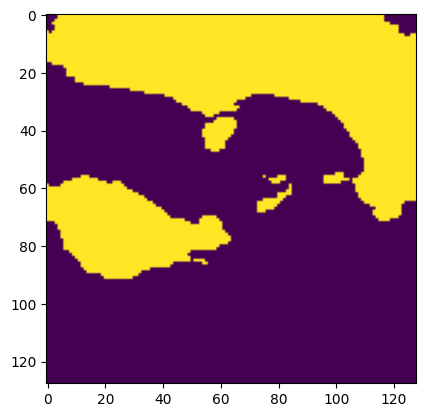

Epoch 8, Loss: 1.9926


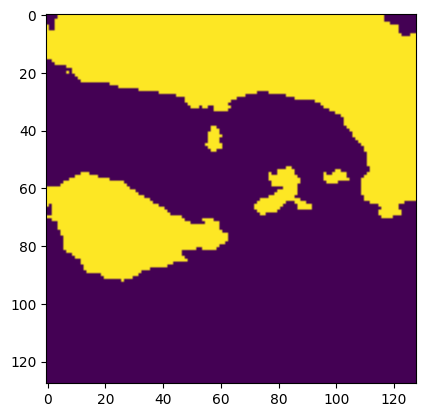

Epoch 9, Loss: 2.2412


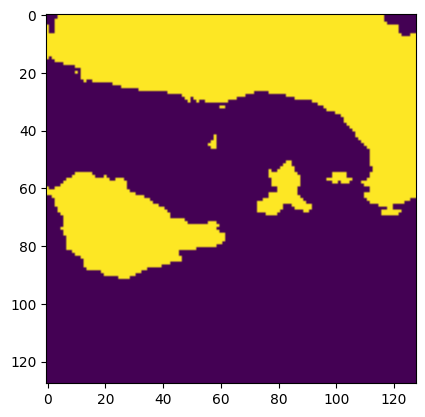

Epoch 10, Loss: -0.1663


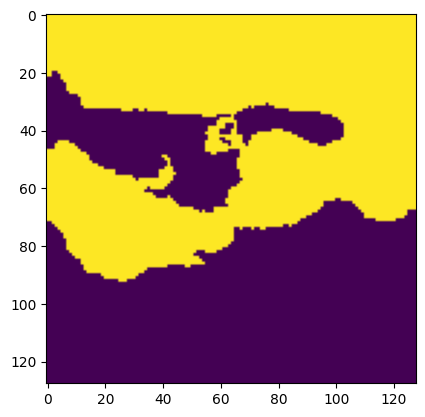

Epoch 11, Loss: 1.9982


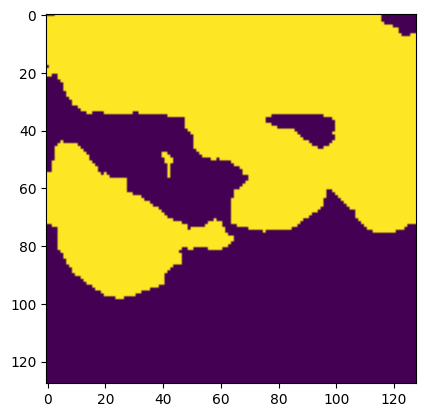

Epoch 12, Loss: 1.7965


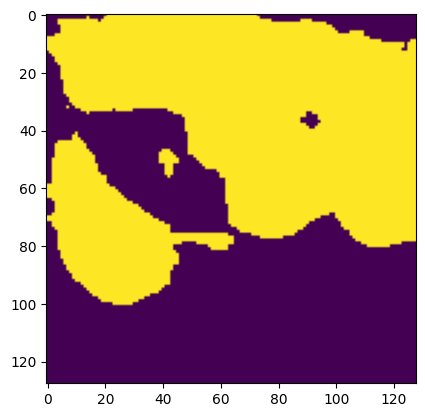

Epoch 13, Loss: 1.9684


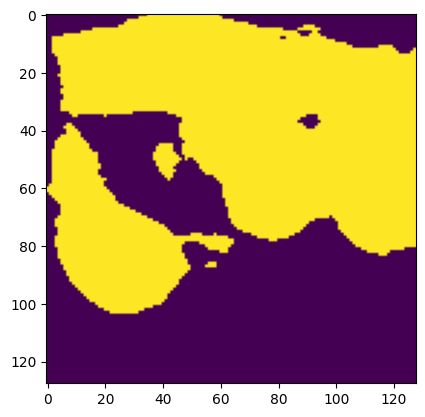

Epoch 14, Loss: 1.9678


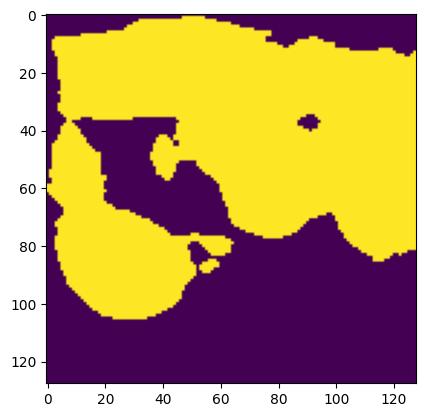

Epoch 15, Loss: 1.9665


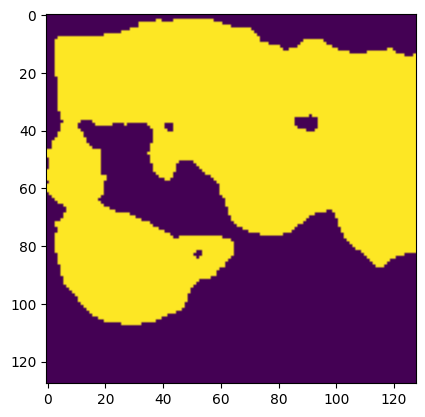

Epoch 16, Loss: 1.9644


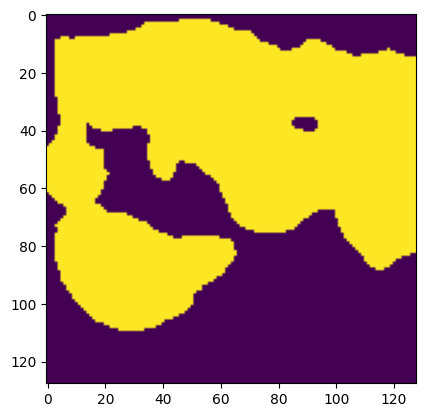

Epoch 17, Loss: 1.9587


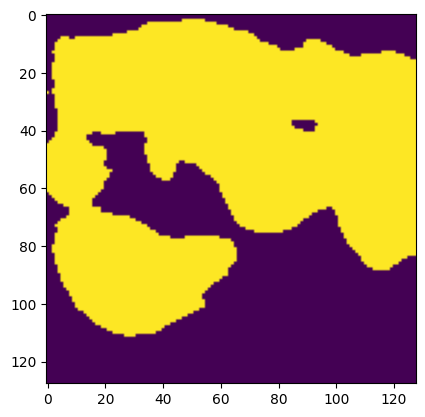

Epoch 18, Loss: 1.9796


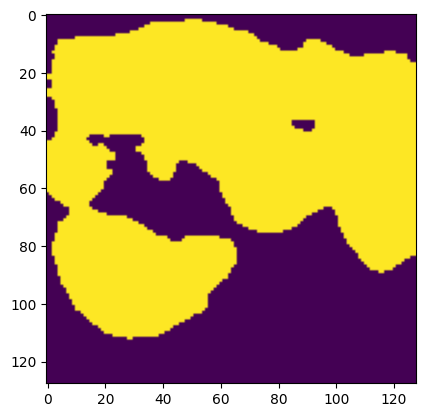

Epoch 19, Loss: 1.9693


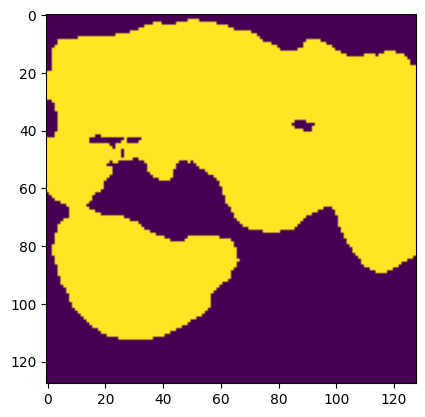

Epoch 20, Loss: 1.9678


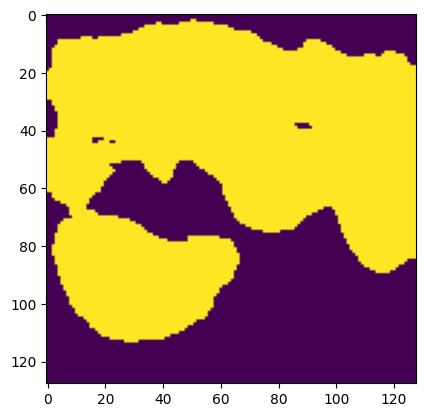

Epoch 21, Loss: 1.9685


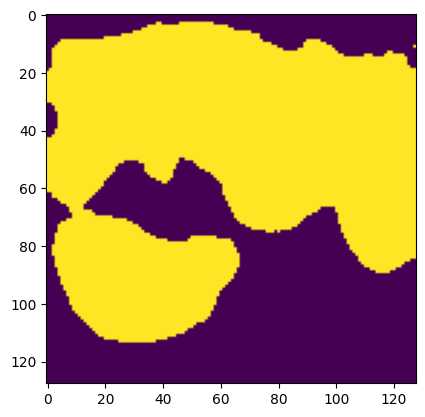

Epoch 22, Loss: 1.9588


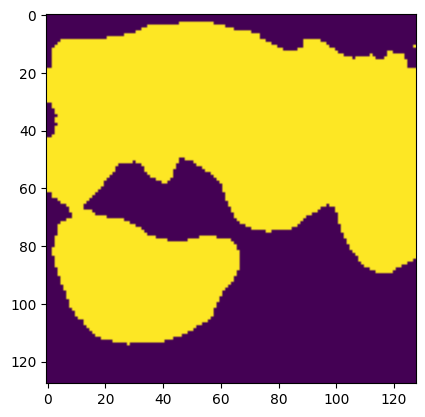

Epoch 23, Loss: 1.9645


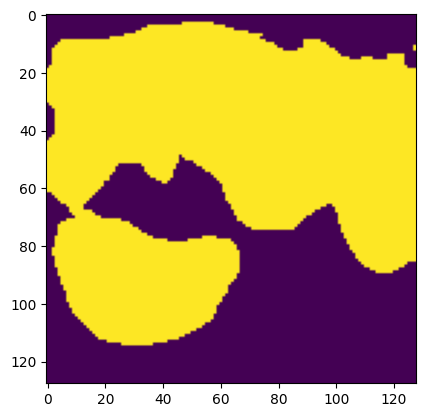

Epoch 24, Loss: 1.9680


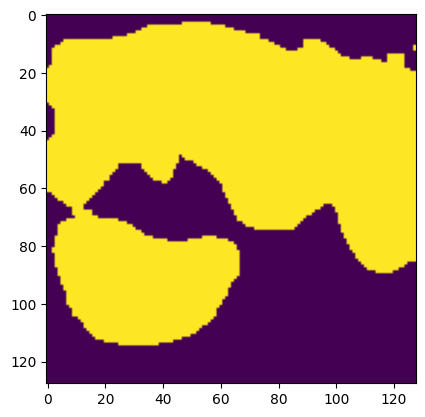

Epoch 25, Loss: 1.9733


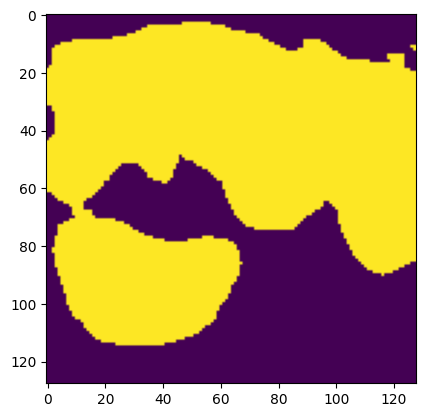

Epoch 26, Loss: 1.8745


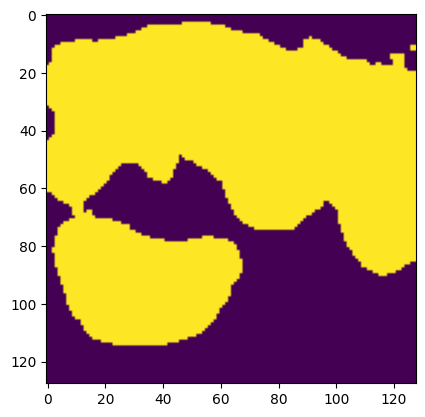

Epoch 27, Loss: 1.8475


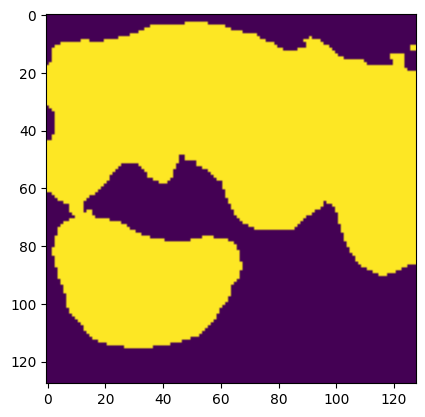

Epoch 28, Loss: 1.9672


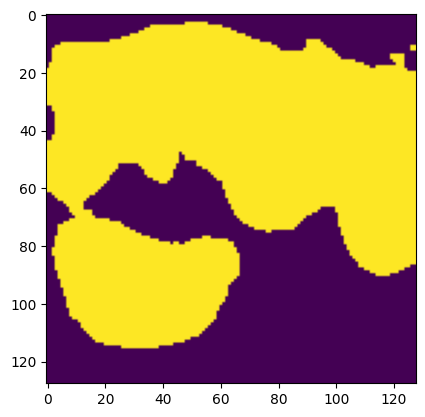

Epoch 29, Loss: 1.9637


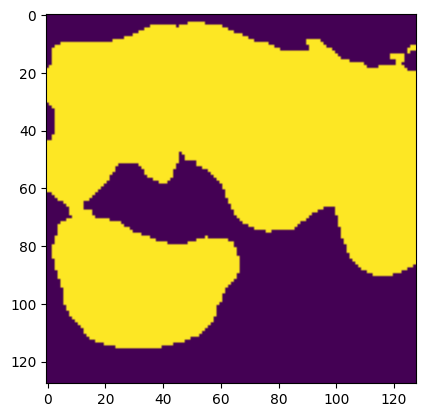

KeyboardInterrupt: 

In [53]:
for epoch in range(1000):
    image_pred, contour_pred = model(image)

    # nodule_image_pred = image_pred[:, 0:1][seg_type==1]
    # gland_image_pred = image_pred[:, 1:2][seg_type==2]
    # nodule_image_mask = mask[seg_type==1]
    # gland_image_mask = mask[seg_type==2]

    nodule_contour_pred = contour_pred[:, 0:1][seg_type==1]
    gland_contour_pred = contour_pred[:, 1:2][seg_type==2]
    nodule_contour_mask = contour[seg_type==1]
    gland_contour_mask = contour[seg_type==2]

    # nodule_image_loss = image_loss_fn_nodule(nodule_image_pred, nodule_image_mask)
    # gland_image_loss = image_loss_fn_gland(gland_image_pred, gland_image_mask)
    
    nodule_contour_loss = contour_loss_fn_nodule(nodule_contour_pred, nodule_contour_mask)
    gland_contour_loss = contour_loss_fn_gland(gland_contour_pred, gland_contour_mask)
    
    loss = nodule_contour_loss + gland_contour_loss

    # nodule_image_IOU = IOU_score(nodule_image_pred, nodule_image_mask)
    # gland_image_IOU = IOU_score(gland_image_pred, gland_image_mask)
    
    # IOU = (nodule_image_IOU + gland_image_IOU) / 2
    
    # dice_loss = DiceLoss()

    # nodule_image_DICE = 1 - dice_loss(nodule_image_pred, nodule_image_mask)
    # gland_image_DICE = 1 - dice_loss(gland_image_pred, gland_image_mask)
    
    # DICE = (nodule_image_DICE + gland_image_DICE) / 2
    
    # Backward and optimize
    optimizer.zero_grad()   # clear previous gradients
    loss.backward()         # compute gradients
    optimizer.step()        # update weights

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    nodule_contour_show = torch.sigmoid(nodule_contour_pred)
    nodule_contour_show = (nodule_contour_show > 0.5)
    plt.imshow(nodule_contour_show[0][0].detach().cpu().numpy())
    plt.show()

In [ ]:
plt.imshow(nodule_contour_pred[index][0].detach().cpu().numpy())

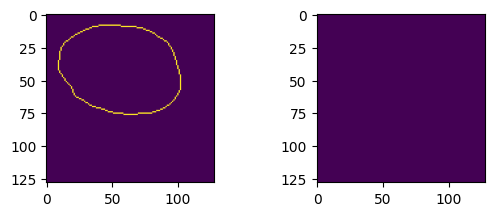

In [44]:
index = 8
# plt.subplot(2,2,1)
# plt.imshow(nodule_image_mask[index][0].detach().cpu().numpy())
# nodule_image_pred = (nodule_image_pred > 0.5)
# plt.subplot(2,2,2)
# plt.imshow(nodule_image_pred[index][0].detach().cpu().numpy())

plt.subplot(2,2,1)
plt.imshow(nodule_contour_mask[index][0].detach().cpu().numpy())
nodule_contour_show = torch.sigmoid(nodule_contour_pred)
nodule_contour_show = (nodule_contour_show > 0.5)
plt.subplot(2,2,2)
plt.imshow(nodule_contour_show[index][0].detach().cpu().numpy())

In [26]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(gland_mask[index][0].detach().cpu().numpy())
# gland_output = (gland_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(gland_output[index][0].detach().cpu().numpy())

In [27]:
def train(dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, seg_type in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)

        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]
        
        gland_output = outputs[:, 1:2, :, :][seg_type==2]
        gland_mask = mask[seg_type==2]

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        gland_loss = loss_fn_gland(gland_output, gland_mask)


        
        loss = nodule_loss + gland_loss
        IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2

        dice_loss = DiceLoss()
        DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    DDTI_total_loss = 0
    TN3K_total_loss = 0
    
    total_IOU = 0
    DDTI_total_IOU = 0
    TN3K_total_IOU = 0
    
    total_DICE = 0
    DDTI_total_DICE = 0
    TN3K_total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]


        DDTI_nodule_output = nodule_output[from_dataset==1]
        TN3K_nodule_output = nodule_output[from_dataset==3]

        DDTI_nodule_mask = nodule_mask[from_dataset==1]
        TN3K_nodule_mask = nodule_mask[from_dataset==3]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        DDTI_nodule_loss = loss_fn_nodule(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_nodule_loss = loss_fn_nodule(TN3K_nodule_output, TN3K_nodule_mask)
        
        IOU = IOU_score(nodule_output, nodule_mask)
        DDTI_IOU = IOU_score(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_IOU = IOU_score(TN3K_nodule_output, TN3K_nodule_mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)
        DDTI_DICE = 1 - dice_loss(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_DICE = 1 - dice_loss(TN3K_nodule_output, TN3K_nodule_mask)
    

        total_loss += nodule_loss.item()
        DDTI_total_loss += DDTI_nodule_loss.item()
        TN3K_total_loss += TN3K_nodule_loss.item()
        
        total_IOU += IOU.item()
        DDTI_total_IOU += DDTI_IOU.item()
        TN3K_total_IOU += TN3K_IOU.item()
        
        total_DICE += DICE.item()
        DDTI_total_DICE += DDTI_DICE.item()
        TN3K_total_DICE += TN3K_DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), DDTI_total_loss/len(dataloader), DDTI_total_IOU/len(dataloader), DDTI_total_DICE/len(dataloader), TN3K_total_loss/len(dataloader), TN3K_total_IOU/len(dataloader), TN3K_total_DICE/len(dataloader), 

In [28]:
epochs = 50
lr = 0.001
project = "thyroid_hybrid_model"
# name=name="PMFSNet_crop_DDTI_standardization_aug_affine(0.5)_hflip(0.5)_lr_0.001"
# name = "HarDnet_crop_DDTI_standardization_aug_affine(0.5)_lr_0.005"
# name = "LightMed_crop_DDTI"
# name = "test"
# name = "HarDnetMSEG_baseline"
name = "hybrid_v4_baseline"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [29]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[10, 20, 48, 96],
#         # embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
# model = HarDMSEG(in_channels = 1, out_channels = 2)
# model = LightMed(in_channels = 1, out_channels = 2, image_size = image_size)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")
model =  HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)

In [30]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}, model : {model}")

image size : 128, lr : 0.001, epochs : 50, batch size : 100, model : HybridSegModel(
  (backbone): HarDNetBackbone(
    (base_conv_1): ConvLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
    )
    (base_conv_2): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
    )
    (base_max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (encoder_blocks): ModuleList(
      (0): EncoderBlock(
        (hardblock): HarDBlock(
          (layers): ModuleList(
            (0): ConvLayer(
              (conv): Conv2d(64, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (norm): Batc

### If using pretrained model

In [31]:
# pretrained_name = "PMFSNet_baseline"
# # model = HarDMSEG(in_channels = 1)
# model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# checkpoint = torch.load(f"models/{pretrained_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])

In [32]:
# loss_fn = DiceLoss()
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [33]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, DDTI_total_loss_val, DDTI_total_IOU_val, DDTI_total_DICE_val, TN3K_total_loss_val, TN3K_total_IOU_val, TN3K_total_DICE_val = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,

        "DDTI_val_loss": DDTI_total_loss_val,
        "DDTI_val_IOU": DDTI_total_IOU_val,
        "DDTI_val_DICE": DDTI_total_DICE_val,

        "TN3K_val_loss": TN3K_total_loss_val,
        "TN3K_val_IOU": TN3K_total_IOU_val,
        "TN3K_val_DICE": TN3K_total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 65/65 [02:17<00:00,  2.12s/it]


train loss : 1.5676540576494657, train IOU : 0.49147199598642494, train DICE : 0.5858914586213919


100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


val loss : 0.9443813516543462, val IOU : 0.4258478283882141, val DICE : 0.5914853857113764
epoch : 1


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 1.040482603586637, train IOU : 0.6263256219717173, train DICE : 0.7678200813440176


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.831899092747615, val IOU : 0.4658553348137782, val DICE : 0.6338094151937045
epoch : 2


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.9184813701189481, train IOU : 0.6693175123288081, train DICE : 0.8018625635367174


100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


val loss : 0.7855929686472967, val IOU : 0.5007804517562573, val DICE : 0.6739070277947646
epoch : 3


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.8563471234761751, train IOU : 0.6926214108100304, train DICE : 0.8168062109213609


100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


val loss : 0.8484527560380789, val IOU : 0.47213626366395217, val DICE : 0.6512032151222229
epoch : 4


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.7891300265605633, train IOU : 0.716511686031635, train DICE : 0.8353043932181138


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.8702697983154883, val IOU : 0.4597056187116183, val DICE : 0.64989900130492
epoch : 5


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.7342162966728211, train IOU : 0.7364094284864572, train DICE : 0.8489457203791692


100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


val loss : 0.6912888059249291, val IOU : 0.5644152072759775, val DICE : 0.7289770520650424
epoch : 6


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.7033137596570529, train IOU : 0.7476504335036644, train DICE : 0.8570861999805157


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.7574362479723417, val IOU : 0.5481427724544818, val DICE : 0.7053376252834613
epoch : 7


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.6719483458078824, train IOU : 0.7593314510125381, train DICE : 0.8641530678822444


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.666551241507897, val IOU : 0.5768225284723135, val DICE : 0.7307635224782504
epoch : 8


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.6321619143852821, train IOU : 0.7733376741409301, train DICE : 0.8740507217553946


100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


val loss : 0.6297316734607403, val IOU : 0.5985229015350342, val DICE : 0.7492468219537002
epoch : 9


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.6101040986868052, train IOU : 0.7822184498493489, train DICE : 0.8786996437953069


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.6302338242530823, val IOU : 0.6077814789918753, val DICE : 0.7578446085636432
epoch : 10


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.5799933649026431, train IOU : 0.7930509227972764, train DICE : 0.8861626047354478


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.687390923500061, val IOU : 0.5935124250558707, val DICE : 0.7383068937521714
epoch : 11


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.5499865651130676, train IOU : 0.8029938055918767, train DICE : 0.8931765409616323


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.6637809368280264, val IOU : 0.6160316879932697, val DICE : 0.771647939315209
epoch : 12


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.5360339806630061, train IOU : 0.8084231862655052, train DICE : 0.8958802828421959


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.6870631392185504, val IOU : 0.599530985722175, val DICE : 0.7641651951349698
epoch : 13


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.5068313424403851, train IOU : 0.8180629895283625, train DICE : 0.9034132214692923


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.593281837610098, val IOU : 0.633396355005411, val DICE : 0.7786755378429706
epoch : 14


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.5029836186995873, train IOU : 0.8206316205171439, train DICE : 0.9042371529799241


100%|██████████| 13/13 [00:03<00:00,  4.17it/s]


val loss : 0.6581571927437415, val IOU : 0.6232842986400311, val DICE : 0.7760517918146573
epoch : 15


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.4885286170702714, train IOU : 0.825598525083982, train DICE : 0.9078224658966064


100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


val loss : 0.7283866772284875, val IOU : 0.5947739390226511, val DICE : 0.7503557663697463
epoch : 16


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.44864088251040535, train IOU : 0.8403247585663429, train DICE : 0.916829041334299


100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


val loss : 0.614047123835637, val IOU : 0.6468655833831201, val DICE : 0.7994187153302706
epoch : 17


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.42872747778892517, train IOU : 0.846922086752378, train DICE : 0.921907850412222


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.6358850185687726, val IOU : 0.6428822829173162, val DICE : 0.7969745718515836
epoch : 18


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.39674770511113683, train IOU : 0.8587695149274973, train DICE : 0.928868607374338


100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


val loss : 0.5997111247136042, val IOU : 0.6590312719345093, val DICE : 0.8142488598823547
epoch : 19


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.40319948058861954, train IOU : 0.8558168860582205, train DICE : 0.9270645664288447


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.6131205696326035, val IOU : 0.6624994002855741, val DICE : 0.8108667181088374
epoch : 20


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.38680041157282313, train IOU : 0.8621625698529757, train DICE : 0.9311077319658719


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.5911811544344976, val IOU : 0.6587722484882061, val DICE : 0.8139892999942486
epoch : 21


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.36143060005628147, train IOU : 0.8705240845680237, train DICE : 0.9365692872267503


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.6305265243236835, val IOU : 0.661010008591872, val DICE : 0.8161482306627127
epoch : 22


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.3456478462769435, train IOU : 0.8760465062581576, train DICE : 0.9401446975194491


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.6753035760842837, val IOU : 0.6629531979560852, val DICE : 0.8131026258835425
epoch : 23


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.33214099636444677, train IOU : 0.8810552587875953, train DICE : 0.9428327853863055


100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


val loss : 0.6241328028532175, val IOU : 0.6689013609519372, val DICE : 0.8203782806029687
epoch : 24


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.3188092240920434, train IOU : 0.8861223239165086, train DICE : 0.9450775256523719


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.6811755162018996, val IOU : 0.682478510416471, val DICE : 0.8259310905749981
epoch : 25


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.3033615208589114, train IOU : 0.8914026122826796, train DICE : 0.9484305794422443


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.591651955476174, val IOU : 0.6970646518927354, val DICE : 0.8345762353677016
epoch : 26


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.2900605185673787, train IOU : 0.8959402689566979, train DICE : 0.9508100188695467


100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


val loss : 0.7293785581221948, val IOU : 0.668690773156973, val DICE : 0.810573032269111
epoch : 27


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.28631541224626395, train IOU : 0.8974281595303462, train DICE : 0.9514346966376671


100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


val loss : 0.6366285956822909, val IOU : 0.6901136178236741, val DICE : 0.8316150995401236
epoch : 28


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.2694016612493075, train IOU : 0.9026713728904724, train DICE : 0.9550314233853266


100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


val loss : 0.6744207052084116, val IOU : 0.6922538601435148, val DICE : 0.8377354282599229
epoch : 29


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.2590923866400352, train IOU : 0.906505547120021, train DICE : 0.9568912295194772


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.8340627275980436, val IOU : 0.6696480558468745, val DICE : 0.8233626026373643
epoch : 30


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.24326209104978122, train IOU : 0.9121129907094515, train DICE : 0.9598002360417293


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.6484556198120117, val IOU : 0.7082313436728257, val DICE : 0.8388896676210257
epoch : 31


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.22935599638865545, train IOU : 0.9174300936552194, train DICE : 0.9621538263100844


100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


val loss : 0.7585894832244287, val IOU : 0.6986161699661841, val DICE : 0.8380943032411429
epoch : 32


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.22075135043034186, train IOU : 0.9200649545742915, train DICE : 0.963872072329888


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.7453473393733685, val IOU : 0.7083202050282404, val DICE : 0.8441574344268212
epoch : 33


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.20949435967665453, train IOU : 0.9242664749805743, train DICE : 0.9657813814970163


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.7420344948768616, val IOU : 0.7139055820611807, val DICE : 0.8477441989458524
epoch : 34


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.20006899237632753, train IOU : 0.9276572575935951, train DICE : 0.9675551579548762


100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


val loss : 0.7617133122224075, val IOU : 0.7134498357772827, val DICE : 0.8475709786781898
epoch : 35


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.19168580449544467, train IOU : 0.9302039128083449, train DICE : 0.9688228130340576


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.7571725524388827, val IOU : 0.7202132252546457, val DICE : 0.8526495557564956
epoch : 36


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.183868424479778, train IOU : 0.9333164646075323, train DICE : 0.9703280403063848


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.7572458707369291, val IOU : 0.7223504093977121, val DICE : 0.8526716415698712
epoch : 37


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.17384969133597153, train IOU : 0.9366710653671851, train DICE : 0.972093979211954


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.822954576749068, val IOU : 0.7174166120015658, val DICE : 0.8523057561654311
epoch : 38


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.16774224088742182, train IOU : 0.9387639504212599, train DICE : 0.9730678870127751


100%|██████████| 13/13 [00:03<00:00,  4.10it/s]


val loss : 0.8606597964580243, val IOU : 0.7202628209040716, val DICE : 0.8527579857752874
epoch : 39


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.1622927237015504, train IOU : 0.9408403405776391, train DICE : 0.9740487832289476


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


val loss : 0.8714930827801044, val IOU : 0.7242627923305218, val DICE : 0.8540512827726511
epoch : 40


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.15462095783307003, train IOU : 0.943575644493103, train DICE : 0.975388724070329


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.9061798820128808, val IOU : 0.7230198245782119, val DICE : 0.8526411239917462
epoch : 41


100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


train loss : 0.1503597665291566, train IOU : 0.9453351708558889, train DICE : 0.9760971188545227


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.9085791248541611, val IOU : 0.7272660090373113, val DICE : 0.8551625792796795
epoch : 42


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.14574729272952447, train IOU : 0.9468671817045945, train DICE : 0.976865488749284


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.9904428995572604, val IOU : 0.7220923121158893, val DICE : 0.8527090824567355
epoch : 43


100%|██████████| 65/65 [00:28<00:00,  2.32it/s]


train loss : 0.14262775411972634, train IOU : 0.94793677513416, train DICE : 0.9774139679395235


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.9769184910334073, val IOU : 0.7253768398211553, val DICE : 0.8549419412246118
epoch : 44


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.14035692123266366, train IOU : 0.9488299434001629, train DICE : 0.9776758221479562


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 0.9937525529127854, val IOU : 0.7238523639165438, val DICE : 0.8546978693742019
epoch : 45


100%|██████████| 65/65 [00:28<00:00,  2.32it/s]


train loss : 0.13768183611906493, train IOU : 0.9498400275523846, train DICE : 0.9782440506494963


100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


val loss : 1.017182483122899, val IOU : 0.7257229227286118, val DICE : 0.8550660564349248
epoch : 46


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.13635545418812678, train IOU : 0.9503751672231234, train DICE : 0.9784566145676833


100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


val loss : 1.0072557009183443, val IOU : 0.7272211955143855, val DICE : 0.8558895817169776
epoch : 47


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.1347159001689691, train IOU : 0.9509076631986177, train DICE : 0.9786438052470867


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


val loss : 1.0024332358286931, val IOU : 0.727833669919234, val DICE : 0.8558721358959491
epoch : 48


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.13391112994689208, train IOU : 0.951243322629195, train DICE : 0.978809615281912


100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


val loss : 1.0013078542856069, val IOU : 0.7282093442403353, val DICE : 0.8560047012109023
epoch : 49


100%|██████████| 65/65 [00:27<00:00,  2.32it/s]


train loss : 0.1337906437424513, train IOU : 0.9514646658530602, train DICE : 0.9788126395298884


100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


val loss : 1.0233374008765588, val IOU : 0.7266041682316706, val DICE : 0.8553725205934964


DDTI_val_DICE,▂▃▄▂▁▅▆▆▇▅▇▆▅▇▇▇█▇▇▇▆▇█▆█▇████████▇█████
DDTI_val_IOU,▃▄▂▁▆▇▇▇▆▇█▆▅▇▆▇█▇▇▇█▆▇▇▆▇▇█▇██▇█▇█▇▇▇▇▇
DDTI_val_loss,▃▂▂▃▃▂▁▁▁▂▂▁▂▂▂▂▂▂▂▃▄▃▃▅▃▄▄▅▅▅▆▆▇▇██████
Learning Rate,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
TN3K_val_DICE,▁▂▃▃▃▄▄▅▅▅▅▅▆▅▆▆▇▆▇▇▇▇▇▇▇▇██████████████
TN3K_val_IOU,▁▂▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████
TN3K_val_loss,█▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_DICE,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
train_IOU,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
print(max_IOU)

In [ ]:
inference_name = "PMFSNet_baseline"
# model = HarDMSEG(in_channels = 1)
model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/last_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:

total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")


In [ ]:
DICE = 0
# model.to("cuda")
model.eval()
for image, mask in tqdm(test_dataloader):
    image, mask = image, mask
    preds = model(image)
    DICE += (1 - dice_loss(preds, mask)).item()
print(DICE/len(test_dataloader))

In [ ]:
index = 7
plt.subplot(1,2,1)
plt.imshow(preds[index][0])
plt.subplot(1,2,2)
plt.imshow(mask[index][0])

In [ ]:
dice_loss = DiceLoss()
print(1 - dice_loss(preds, mask))

In [ ]:
plt.imshow(mask[index][0])